In [ ]:
# prompt: mount drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Install required packages
!pip install -U sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 49.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 66.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
# Import necessary libraries
import pandas as pd
from collections import Counter
from sentence_transformers import SentenceTransformer
import numpy as np
import sklearn
from sklearn.metrics import (
    precision_score, recall_score, f1_score, accuracy_score,
    mean_squared_error, mean_absolute_error, classification_report, confusion_matrix
)
import seaborn as sn
import matplotlib.pyplot as plt

In [ ]:
# Load datasets
# Adjusting to the comma-separated format and proper headers
train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/train_modified.csv")  # Train dataset has headers
test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/mal_full_offe_test_MODIFY (1).csv", header=None, names=["text", "label"])  # Test dataset lacks headers

In [ ]:
# Prepare data for training and testing
train_sent_m = train['text'].tolist()
train_label_m = train['label'].tolist()

test_sent_m = test['text'].tolist()
test_label_m = test['label'].tolist()

In [ ]:
# Encode labels
from sklearn import preprocessing

# Initialize and fit LabelEncoder on the training labels
le = preprocessing.LabelEncoder()
train_labels_encoded = le.fit_transform(train_label_m)

# Add "unknown" explicitly to LabelEncoder classes
le.classes_ = np.append(le.classes_, "unknown")

# Ensure test labels only include known labels
# Replace unknown labels with "unknown" for proper transformation
known_labels = set(le.classes_)  # Includes "unknown" now
test_label_m_filtered = [label if label in known_labels else "unknown" for label in test_label_m]

# Encode the filtered test labels
test_labels_encoded = le.transform(test_label_m_filtered)

# Verify encoding
print("Classes in LabelEncoder:", le.classes_)

Classes in LabelEncoder: ['Not_offensive' 'Offensive_Untargetede' 'Offensive_target_insult_Group'
 'Offensive_target_insult_individual' 'not-malayalam' 'unknown']


In [ ]:
from sentence_transformers import SentenceTransformer, models

word_embedding_model = models.Transformer('bert-base-multilingual-cased', max_seq_length=128)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(), pooling_mode_mean_tokens=False, pooling_mode_cls_token=True)

# Create custom SentenceTransformer model
trans_model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

In [ ]:
# # Load multilingual embedding model (pretrained model)
# trans_model = SentenceTransformer('bert-base-multilingual-cased')

In [ ]:
# Generate embeddings with batch processing on CPU
train_sentence_embeddings = trans_model.encode(train_sent_m, batch_size=32, show_progress_bar=True)
test_sentence_embeddings = trans_model.encode(test_sent_m, batch_size=32, show_progress_bar=True)

Batches:   0%|          | 0/501 [00:00<?, ?it/s]

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

In [ ]:
# Compute class weights to handle imbalance
class_weights = sklearn.utils.class_weight.compute_class_weight(
    'balanced', classes=np.unique(train_labels_encoded), y=train_labels_encoded
)
print("Computed class weights:", class_weights)

Computed class weights: [ 0.22714053 16.67708333 20.13836478 11.51798561  2.49376947]


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Evaluation Scores:
Macro Metrics:
Accuracy: 0.726
Precision: 0.329
Recall: 0.840
F1 Score: 0.342

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.72      0.83      1765
           1       0.14      0.62      0.23        29
           2       0.00      1.00      0.00         0
           3       0.00      1.00      0.00         0
           4       0.52      0.87      0.65       157

    accuracy                           0.73      1951
   macro avg       0.33      0.84      0.34      1951
weighted avg       0.93      0.73      0.80      1951

Predictions saved to 'Logistic_regression_predictions.csv'.


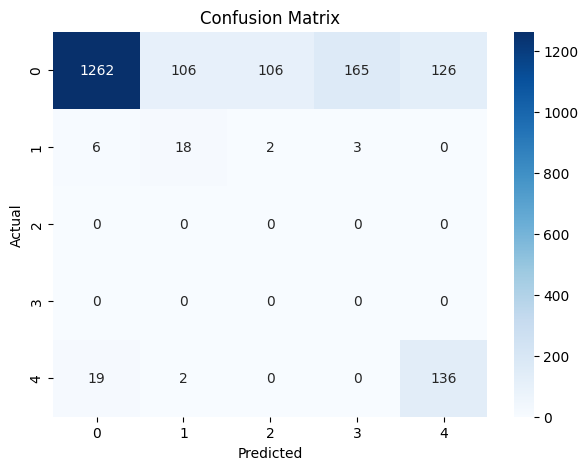

In [ ]:
# Train Logistic Regression model
# Logistic Regression is a statistical model used for binary classification. It predicts the probability of a data point belonging to one of two classes based on
# input features, using a logistic (S-shaped) function to map predictions to probabilities.
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt


# Map class weights into dictionary format
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
# class_weight_dict = {0:0.22607331, 1:23.54117647 ,2:13.69505703 ,3:17.07014218 ,4:2.484}


# Initialize and train the model
model = LogisticRegression(class_weight=class_weight_dict, max_iter=500)
model.fit(train_sentence_embeddings, train_labels_encoded)

# Predict on the test data
expected = test_labels_encoded
predicted = model.predict(test_sentence_embeddings)

# Handle unseen labels in the test data
# Map unseen test labels to a default class to avoid evaluation errors
unique_train_labels = np.unique(train_labels_encoded)
filtered_expected = [label if label in unique_train_labels else -1 for label in expected]
filtered_predicted = [pred if pred in unique_train_labels else -1 for pred in predicted]

# Remove the default class (-1) from filtered labels for evaluation
filtered_expected = np.array(filtered_expected)
filtered_predicted = np.array(filtered_predicted)
valid_indices = filtered_expected != -1
filtered_expected = filtered_expected[valid_indices]
filtered_predicted = filtered_predicted[valid_indices]

# Evaluate model
print("\nEvaluation Scores:")
accuracy = accuracy_score(filtered_expected, filtered_predicted)
recall = recall_score(filtered_expected, filtered_predicted, average="macro", zero_division=1)
precision = precision_score(filtered_expected, filtered_predicted, average="macro", zero_division=1)
f1 = f1_score(filtered_expected, filtered_predicted, average="macro", zero_division=1)

print("Macro Metrics:")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")

# Classification Report
# Fix LabelEncoder issue by fitting it on all possible labels before inverse_transform
all_possible_labels = np.unique(np.concatenate((train_labels_encoded, test_labels_encoded)))
le.fit(all_possible_labels)

# Convert target_names to strings
target_names = list(map(str, le.inverse_transform(unique_train_labels)))

print("\nClassification Report:")
print(classification_report(filtered_expected, filtered_predicted, labels=unique_train_labels, target_names=target_names, zero_division=1))

# Save predictions to a CSV file
# Fix: Ensure correct alignment of test inputs and predicted outputs in the DataFrame
try:
    predictions = le.inverse_transform(predicted)
except ValueError:
    predictions = ["unseen_label" if pred not in unique_train_labels else le.inverse_transform([pred])[0] for pred in predicted]

classified_df = pd.DataFrame({'tweets': test_sent_m, 'actual_label': test_label_m, 'predictions': list(predictions)})
classified_df.to_csv('Logistic_regression_predictions.csv', index=False)
print("Predictions saved to 'Logistic_regression_predictions.csv'.")

# Plot and save confusion matrix
cfm = confusion_matrix(filtered_expected, filtered_predicted, labels=unique_train_labels)
df_cfm = pd.DataFrame(cfm, index=target_names, columns=target_names)
plt.figure(figsize=(7, 5))
cfm_plot = sn.heatmap(df_cfm, annot=True, fmt='g', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig("cfm_LR.png")
plt.show()

Evaluation Scores:
Macro Metrics:
Accuracy: 0.254
Precision: 0.251
Recall: 0.701
F1 Score: 0.164

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.21      0.34      1765
           1       0.04      0.55      0.07        29
           2       0.00      1.00      0.00         0
           3       0.00      1.00      0.00         0
           4       0.28      0.75      0.41       157

    accuracy                           0.25      1951
   macro avg       0.25      0.70      0.16      1951
weighted avg       0.87      0.25      0.34      1951

Predictions saved to 'Naive_Bayes_corrected_predictions.csv'.


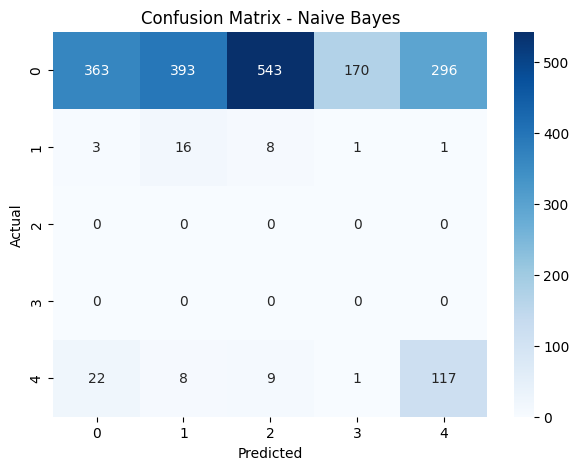

In [ ]:
# Naive Bayes Implementation
# Naive Bayes is a probabilistic model based on Bayes' Theorem. It assumes that features are independent of each other (naive assumption) and calculates the
# likelihood of a data point belonging to a specific class based on these probabilities. It works well with text data and simple datasets.
from sklearn.naive_bayes import GaussianNB, ComplementNB
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score, f1_score,
    classification_report, confusion_matrix
)
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

# Model Initialization
model = GaussianNB()  # You can switch to ComplementNB() for other NB variations.
model.fit(train_sentence_embeddings, train_labels_encoded)

# Use test labels and embeddings for evaluation
expected = test_labels_encoded  # Corrected variable
predicted = model.predict(test_sentence_embeddings)  # Use test embeddings

# Ensure consistent handling of unseen labels
unique_train_labels = np.unique(train_labels_encoded)
filtered_expected = [label if label in unique_train_labels else -1 for label in expected]
filtered_predicted = [pred if pred in unique_train_labels else -1 for pred in predicted]

filtered_expected = np.array(filtered_expected)
filtered_predicted = np.array(filtered_predicted)
valid_indices = filtered_expected != -1
filtered_expected = filtered_expected[valid_indices]
filtered_predicted = filtered_predicted[valid_indices]

# Evaluation Scores
print("Evaluation Scores:")
accuracy = accuracy_score(filtered_expected, filtered_predicted)
recall = recall_score(filtered_expected, filtered_predicted, average="macro", zero_division=1)
precision = precision_score(filtered_expected, filtered_predicted, average="macro", zero_division=1)
f1 = f1_score(filtered_expected, filtered_predicted, average="macro", zero_division=1)

print("Macro Metrics:")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")

# Classification Report
# Use unique_train_labels to ensure alignment with model output
target_names = list(map(str, le.inverse_transform(unique_train_labels)))

print("\nClassification Report:")
print(classification_report(filtered_expected, filtered_predicted, labels=unique_train_labels, target_names=target_names, zero_division=1))

# Save Predictions with Updated Logic
try:
    predictions = le.inverse_transform(predicted)  # Decode predictions
except ValueError:
    # Handle unseen labels
    predictions = [
        "unseen_label" if pred not in unique_train_labels else le.inverse_transform([pred])[0]
        for pred in predicted
    ]

# Ensure the output CSV is properly formatted
classified_df = pd.DataFrame({
    'tweets': test_sent_m,
    'actual_label': list(test_label_m),  # Ensure `test_label_m` is correctly mapped to string labels
    'predictions': list(predictions)
})

# Save the corrected predictions to CSV
output_csv_path = 'Naive_Bayes_corrected_predictions.csv'
classified_df.to_csv(output_csv_path, index=False)
print(f"Predictions saved to '{output_csv_path}'.")

# Confusion Matrix
cfm = confusion_matrix(filtered_expected, filtered_predicted, labels=unique_train_labels)
df_cfm = pd.DataFrame(cfm, index=target_names, columns=target_names)

plt.figure(figsize=(7, 5))
cfm_plot = sn.heatmap(df_cfm, annot=True, fmt='g', cmap='Blues')
plt.title("Confusion Matrix - Naive Bayes")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig("cfm_NB.png")
plt.show()


Eval Scores:
Macro Metrics:
Accuracy: 0.937
Precision: 0.481
Recall: 0.825
F1 Score: 0.449

Classification Report:
                                      precision    recall  f1-score   support

                       Not_offensive       0.97      0.97      0.97      1765
     Offensive_Targeted_Insult_Group       0.65      0.45      0.53        29
Offensive_Targeted_Insult_Individual       0.00      1.00      0.00         0
                Offensive_Untargeted       0.00      1.00      0.00         0
                       Not_Malayalam       0.79      0.71      0.75       157

                            accuracy                           0.94      1951
                           macro avg       0.48      0.83      0.45      1951
                        weighted avg       0.95      0.94      0.94      1951

Predictions saved to 'SVM_linear_labse_corrected.csv'.
Model saved to 'linear_labse_corrected.pkl'.


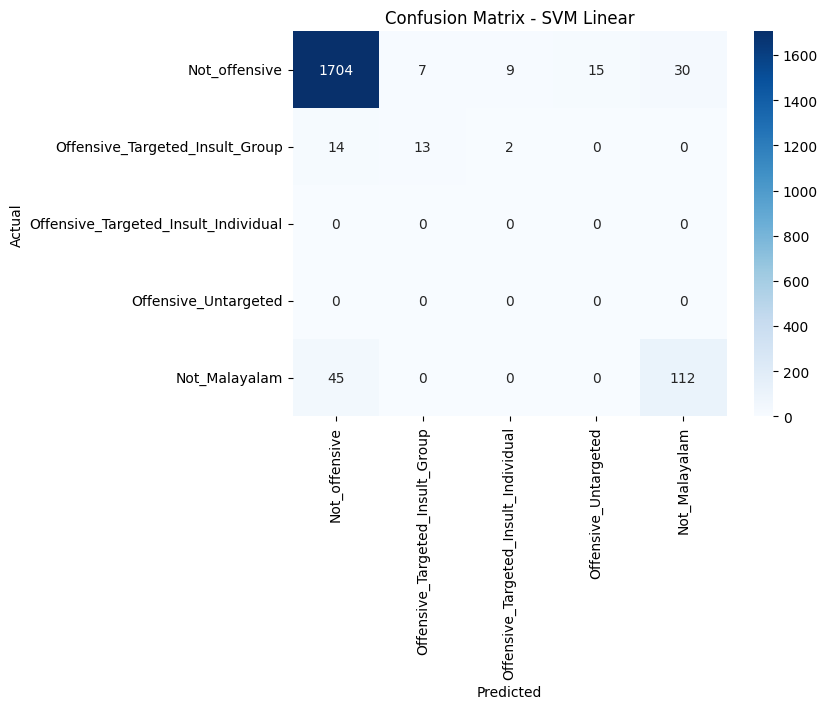

Confusion matrix saved as 'cfm_SVM_linear_corrected.png'.


In [ ]:
# SVM Linear
# Linear SVM is a machine learning model that separates data into classes using a straight line (or hyperplane in higher dimensions). It aims to maximize the
# margin (distance) between the data points of different classes and the dividing line.
#model present
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import pickle

# Ensure required variables are defined
# train_sentence_embeddings, train_labels_encoded, dev_sentence_embeddings, dev_labels_encoded must be initialized
# test_sent_m and test_label_m are assumed to be defined for saving predictions

# Initialize and train the SVM model
model = SVC(kernel='linear', C=10)
model.fit(train_sentence_embeddings, train_labels_encoded)

# Predictions and handling unseen labels
expected = test_labels_encoded
predicted = model.predict(test_sentence_embeddings)

# Handle unseen labels (filter out invalid predictions)
unique_train_labels = np.unique(train_labels_encoded)
filtered_expected = [label if label in unique_train_labels else -1 for label in expected]
filtered_predicted = [pred if pred in unique_train_labels else -1 for pred in predicted]

filtered_expected = np.array(filtered_expected)
filtered_predicted = np.array(filtered_predicted)
valid_indices = filtered_expected != -1
filtered_expected = filtered_expected[valid_indices]
filtered_predicted = filtered_predicted[valid_indices]

# Evaluation Scores
print("Eval Scores:")
accuracy = accuracy_score(filtered_expected, filtered_predicted)
recall = recall_score(filtered_expected, filtered_predicted, average="macro", zero_division=1)
precision = precision_score(filtered_expected, filtered_predicted, average="macro", zero_division=1)
f1 = f1_score(filtered_expected, filtered_predicted, average="macro", zero_division=1)

print("Macro Metrics:")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")

# Classification Report
target_names = ['Not_offensive', 'Offensive_Targeted_Insult_Group',
                'Offensive_Targeted_Insult_Individual', 'Offensive_Untargeted', 'Not_Malayalam']
print("\nClassification Report:")
print(classification_report(filtered_expected, filtered_predicted, labels=unique_train_labels, target_names=target_names, zero_division=1))

# Save predictions
try:
    predictions = list(model.classes_[predicted])  # Decode predictions
except ValueError:
    predictions = [
        "unseen_label" if pred not in unique_train_labels else le.inverse_transform([pred])[0]
        for pred in predicted
    ]

classified_df = pd.DataFrame({
    'tweets': test_sent_m,
    'actual_label': list(test_label_m),  # Ensure test_label_m is correctly decoded
    'predictions': predictions
})

# Save predictions to a CSV
output_csv_path = 'SVM_linear_labse_corrected.csv'
classified_df.to_csv(output_csv_path, index=False)
print(f"Predictions saved to '{output_csv_path}'.")

# Save the trained model
pkl_filename = "linear_labse_corrected.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)
print(f"Model saved to '{pkl_filename}'.")

# Confusion Matrix
cfm = confusion_matrix(filtered_expected, filtered_predicted, labels=unique_train_labels)
df_cfm = pd.DataFrame(cfm, index=target_names, columns=target_names)

plt.figure(figsize=(7, 5))
cfm_plot = sn.heatmap(df_cfm, annot=True, fmt='g', cmap='Blues')
plt.title("Confusion Matrix - SVM Linear")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig("cfm_SVM_linear_corrected.png")
plt.show()
print("Confusion matrix saved as 'cfm_SVM_linear_corrected.png'.")


Evaluation Scores:
Macro Metrics:
Accuracy: 0.936
Precision: 0.624
Recall: 0.706
F1 Score: 0.405

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1765
           1       0.88      0.52      0.65        29
           2       0.00      1.00      0.00         0
           3       0.00      1.00      0.00         0
           4       0.91      0.73      0.81       157

   micro avg       0.94      0.96      0.95      1951
   macro avg       0.55      0.85      0.49      1951
weighted avg       0.95      0.96      0.95      1951

Predictions saved to 'KNN_corrected_predictions.csv'.


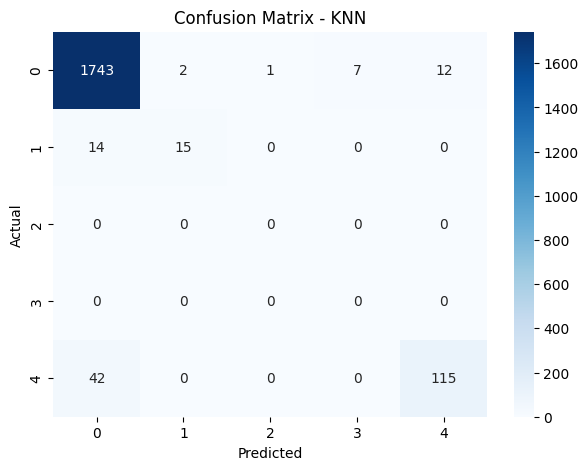

Confusion matrix saved as 'cfm_KNN_corrected.png'.


In [ ]:
# KNN classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score, f1_score,
    classification_report, confusion_matrix
)
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import pickle

# Initialize and train the KNN model
model = KNeighborsClassifier(weights='distance')
model.fit(train_sentence_embeddings, train_labels_encoded)

# Make predictions
expected = test_labels_encoded
predicted = model.predict(test_sentence_embeddings)

# Evaluation Scores
print("Evaluation Scores:")
accuracy = accuracy_score(expected, predicted)
recall = recall_score(expected, predicted, average="macro", zero_division=1)
precision = precision_score(expected, predicted, average="macro", zero_division=1)
f1 = f1_score(expected, predicted, average="macro", zero_division=1)

print("Macro Metrics:")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")

# Classification Report
# Use the correct number of target names based on unique labels in your dataset
unique_labels = np.unique(train_labels_encoded)
target_names = list(map(str, le.inverse_transform(unique_labels)))

print("\nClassification Report:")
print(classification_report(expected, predicted, labels=unique_labels, target_names=target_names, zero_division=1))

# Save Predictions
predictions = list(le.inverse_transform(predicted))  # Decode predictions
classified_df = pd.DataFrame({
    'tweets': test_sent_m,
    'actual_label': list(test_label_m),
    'predictions': predictions
})

# Save predictions to a CSV file
output_csv_path = 'KNN_corrected_predictions.csv'
classified_df.to_csv(output_csv_path, index=False)
print(f"Predictions saved to '{output_csv_path}'.")

# Confusion Matrix
cfm = confusion_matrix(expected, predicted, labels=unique_labels)
df_cfm = pd.DataFrame(cfm, index=target_names, columns=target_names)

plt.figure(figsize=(7, 5))
cfm_plot = sn.heatmap(df_cfm, annot=True, fmt='g', cmap='Blues')
plt.title("Confusion Matrix - KNN")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig("cfm_KNN_corrected.png")
plt.show()
print("Confusion matrix saved as 'cfm_KNN_corrected.png'.")